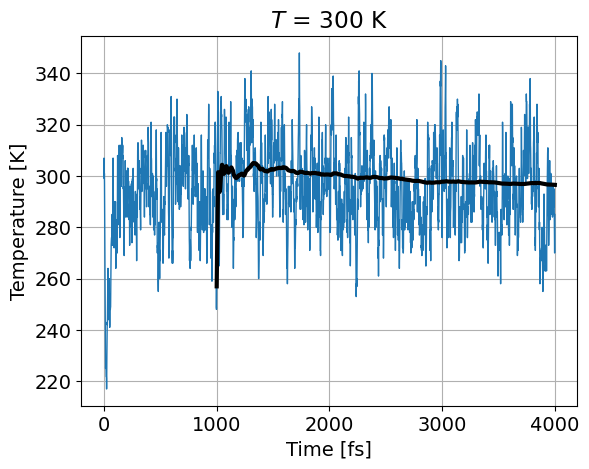

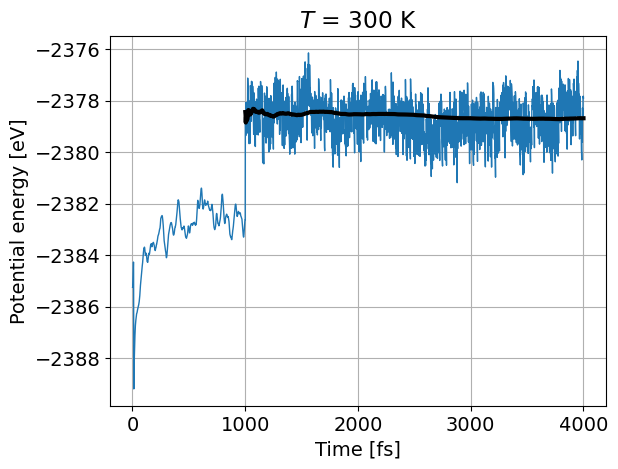

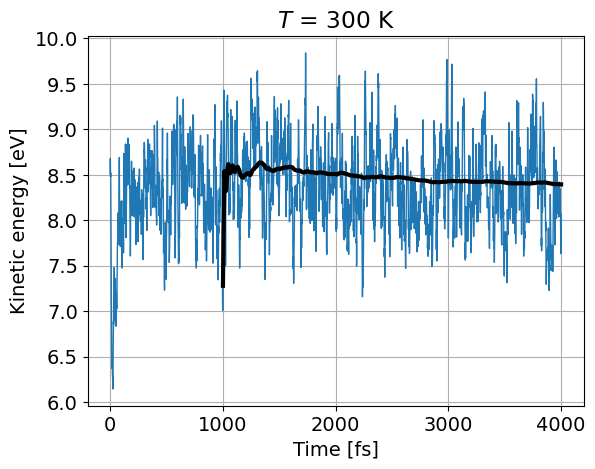

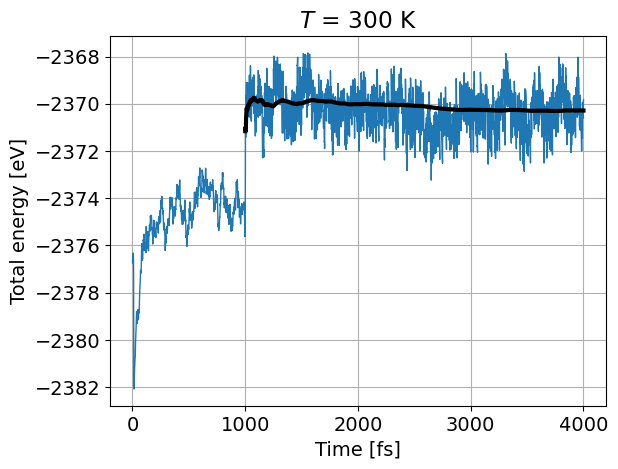

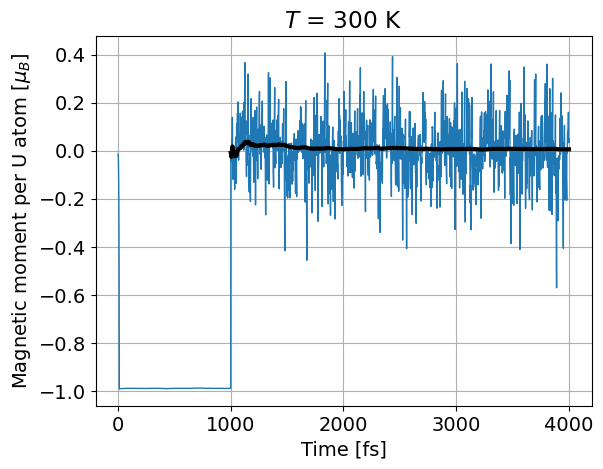

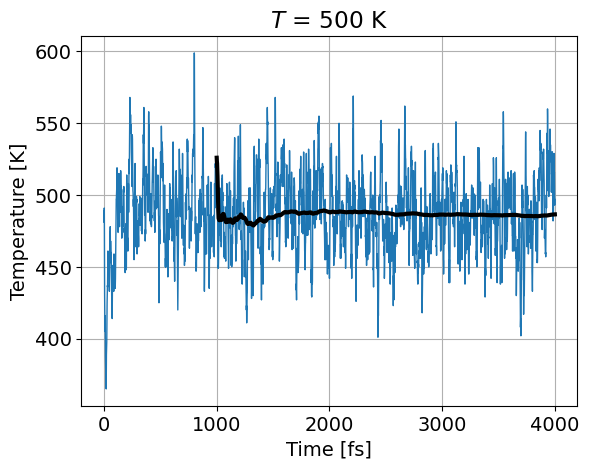

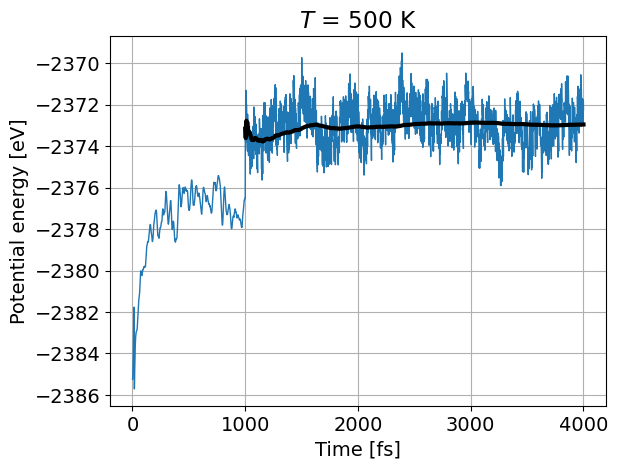

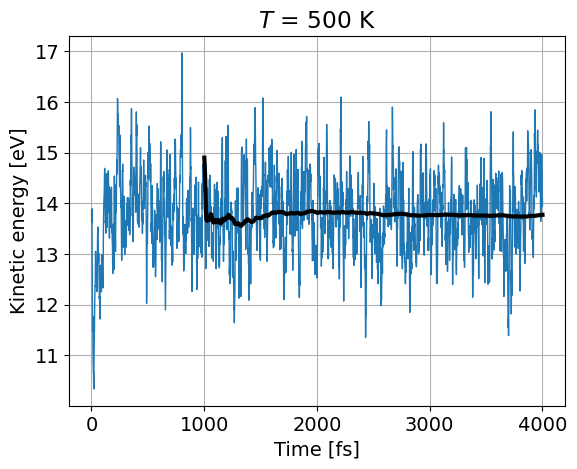

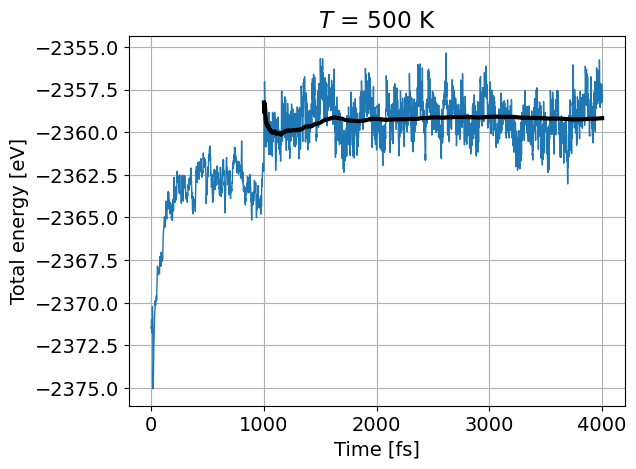

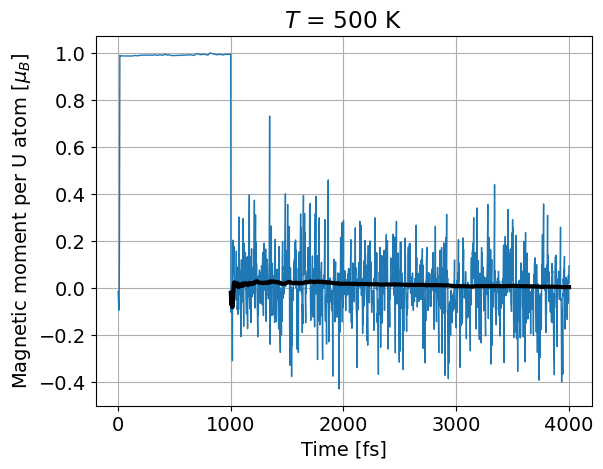

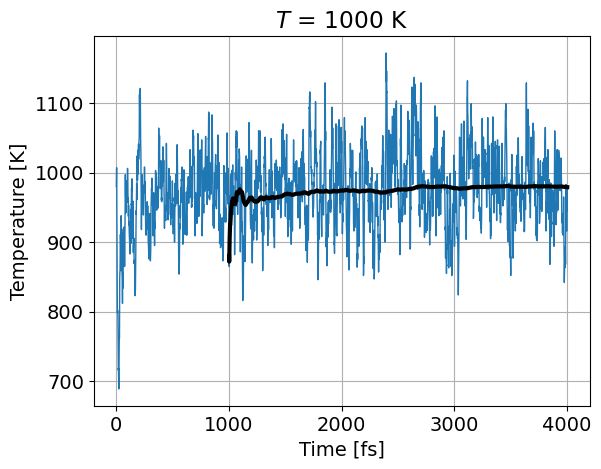

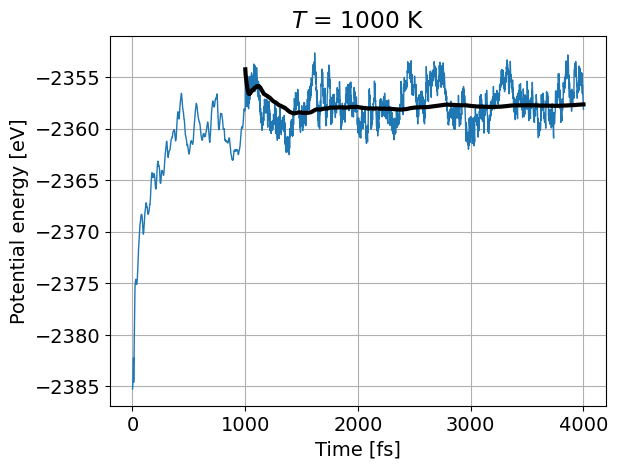

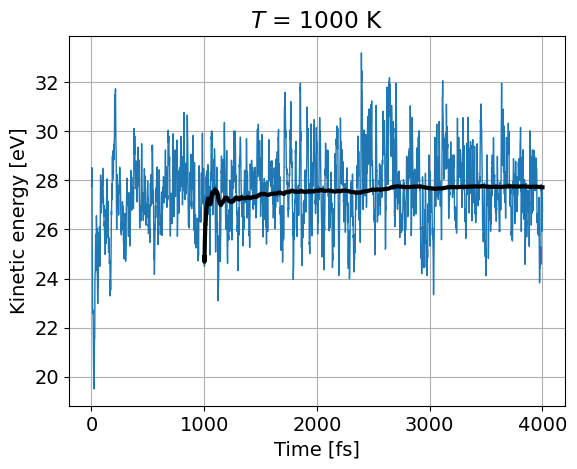

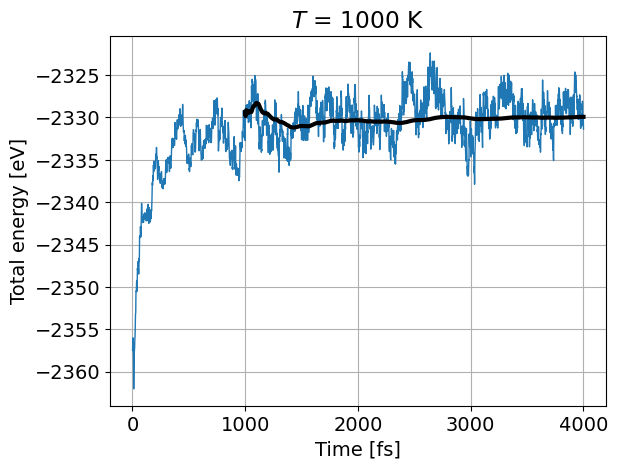

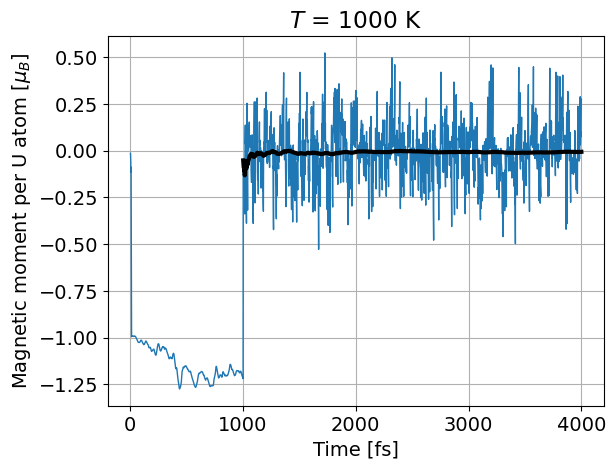

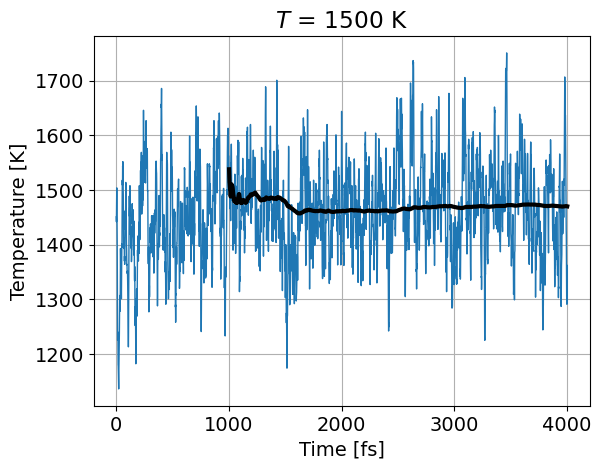

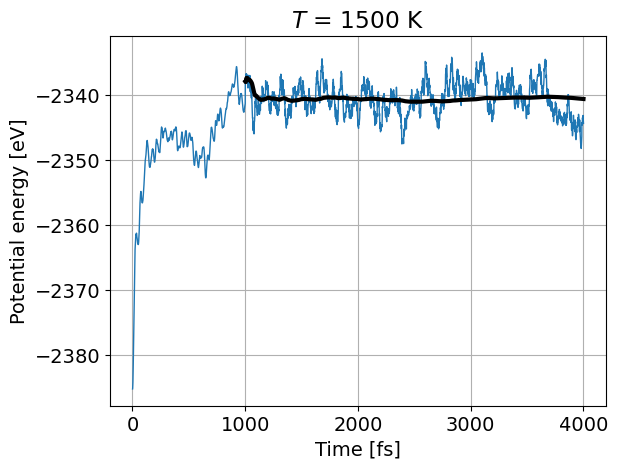

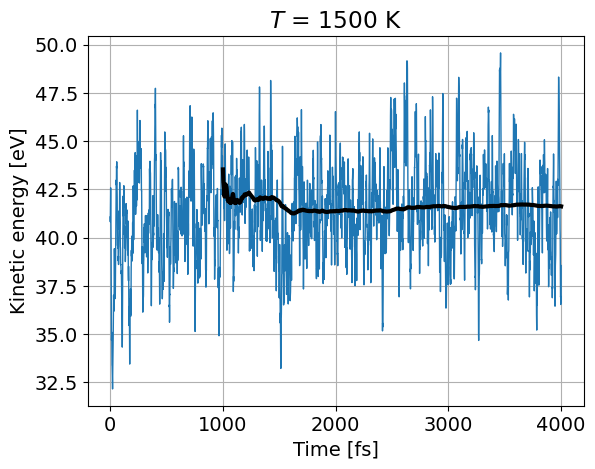

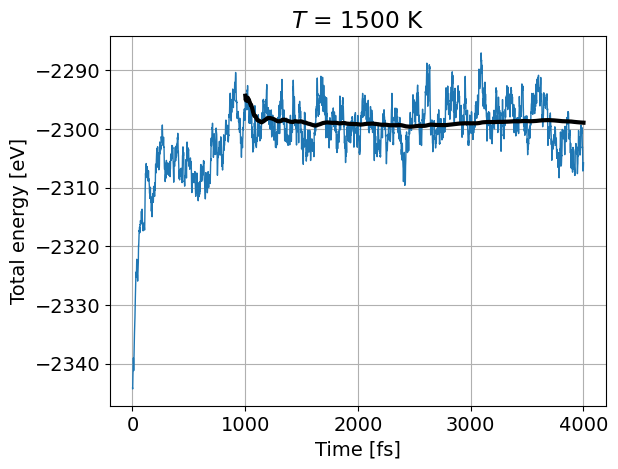

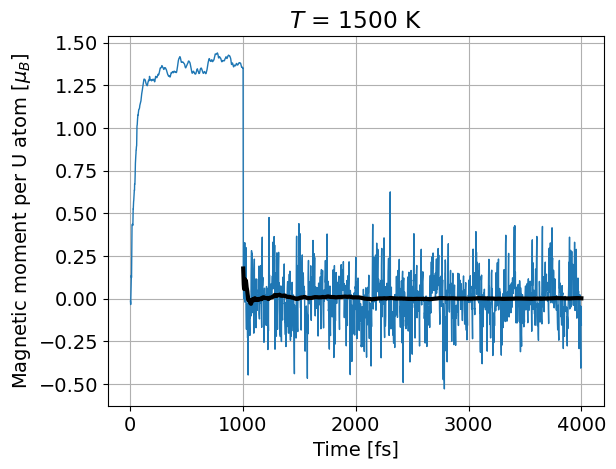

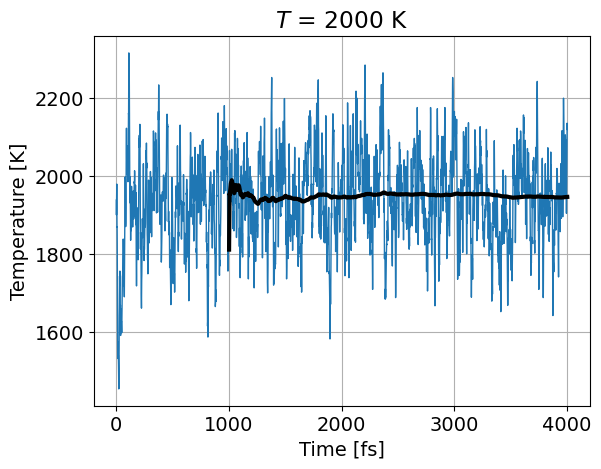

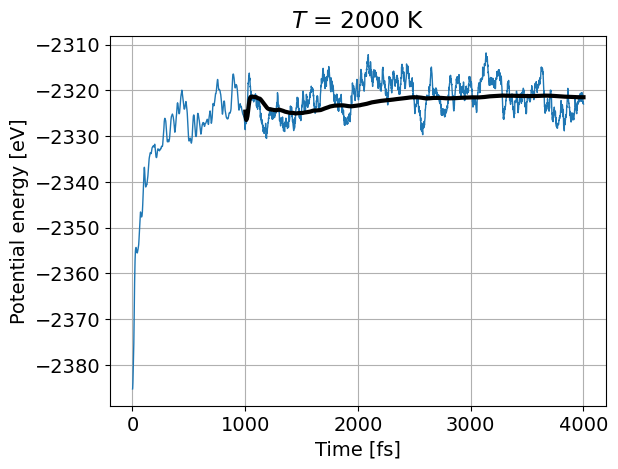

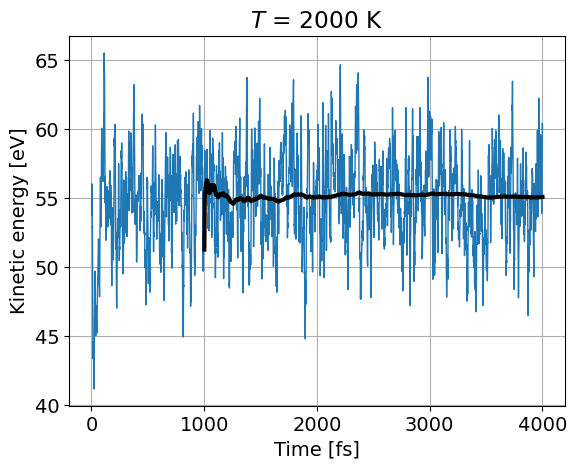

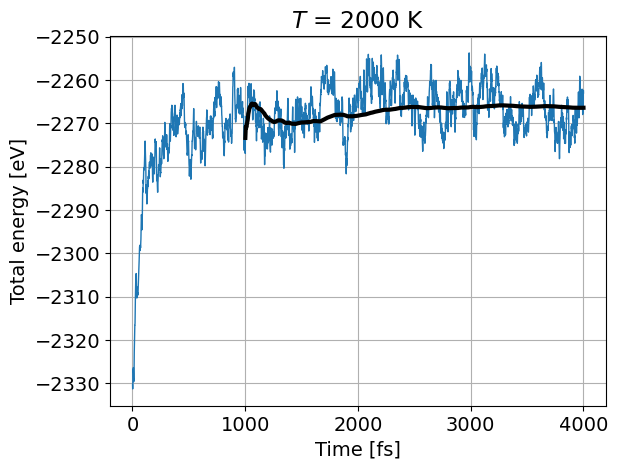

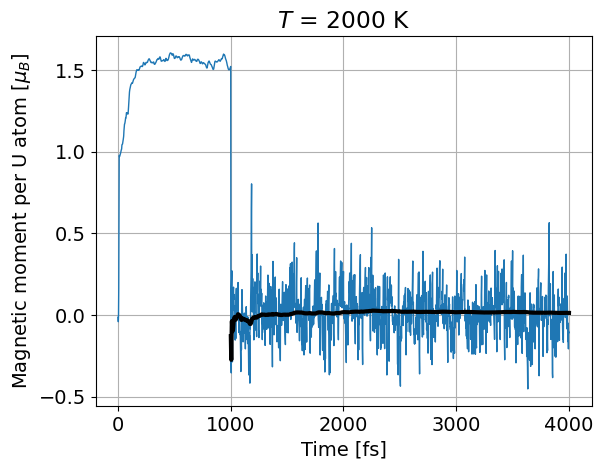

In [1]:
import numpy as np
import csv
import os
import matplotlib.pyplot as mpl
import re
import math
from scipy.optimize import curve_fit

# Image font
# mpl.rcParams["mathtext.fontset"] = "stix"   # Change the math font
# mpl.rcParams["font.family"] = "STIXGeneral" # Change the global font
mpl.rcParams.update({'font.size': 14})

T = [300, 500, 1000, 1500, 2000]

labels = ["Timestep", "T", "PE", "KE", "TotE", "MagMom"]

data = {}
for i in T:
    data[i] = {}
    for j in labels:
        data[i][j] = []

TotE = []
MagMom = []

TotE_sigma = []
MagMom_sigma = []

def running_average(data):
    averages = []
    total = 0    
    for i, value in enumerate(data):
        total += value
        av = total / (i + 1)
        averages.append(av)
    return averages

# HOME = os.getcwd()

HOME = '/home/mohamed/DLM'

# Timestep, T, E, F, E0, EK, SP, SK, mag

for i in T: 
    file = np.genfromtxt(f'{HOME}/formatted_output.{i}.csv', delimiter=',', skip_header=1)
    data[i]["Timestep"] = file[:, 0]
    data[i]["T"] = file[:, 1]
    data[i]["PE"] = file[:, 4]
    data[i]["KE"] = file[:, 5]
    data[i]["TotE"] = data[i]["PE"] + data[i]["KE"]
    data[i]["MagMom"] = file[:, 8]/108

av_frac = 15/40

for i in T:
    TotE.append( np.mean(data[i]["TotE"][int(av_frac*len(data[i]["TotE"])):]) )
    MagMom.append( np.mean(data[i]["MagMom"][int(av_frac*len(data[i]["MagMom"])):]) )
    TotE_sigma.append( np.std(data[i]["TotE"][int(av_frac*len(data[i]["TotE"])):]) )
    MagMom_sigma.append( np.std(data[i]["MagMom"][int(av_frac*len(data[i]["MagMom"])):]) )

labels = {"T": "Temperature [K]", "PE": "Potential energy [eV]", "KE": "Kinetic energy [eV]", "TotE": "Total energy [eV]", "MagMom": "Magnetic moment per U atom [$\mu_B$]"}

for i in T:
    for j in ["T", "PE", "KE", "TotE", "MagMom"]:
        mpl.plot(data[i]["Timestep"], data[i][j], '-', linewidth=1, color='tab:blue')
        mpl.plot(data[i]["Timestep"][1000:], running_average(data[i][j][1000:]), '-', linewidth=3, color='k')
        mpl.xlabel("Time [fs]")
        mpl.ylabel(labels[j])
        mpl.grid("on")
        mpl.savefig(f'{i}-{j}.png', dpi=800, bbox_inches="tight")
        mpl.title(f"$T$ = {i} K")
        mpl.show()

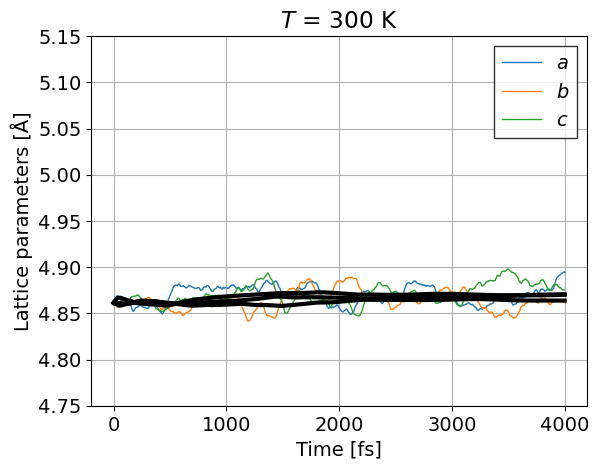

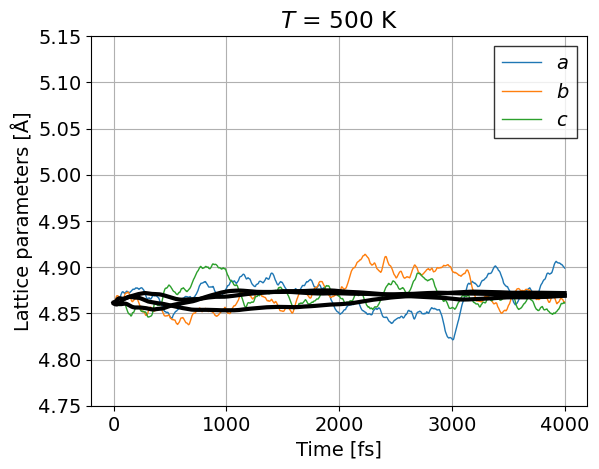

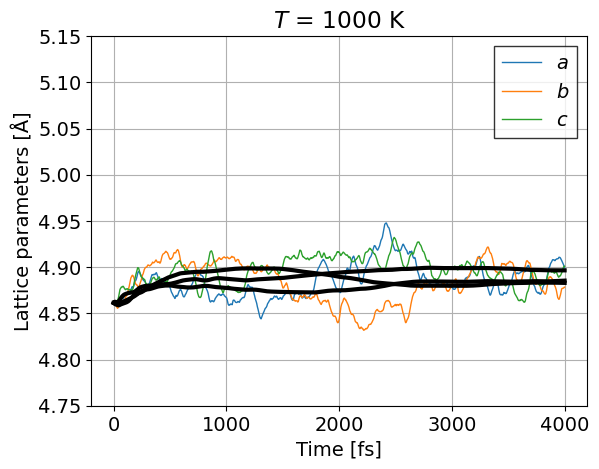

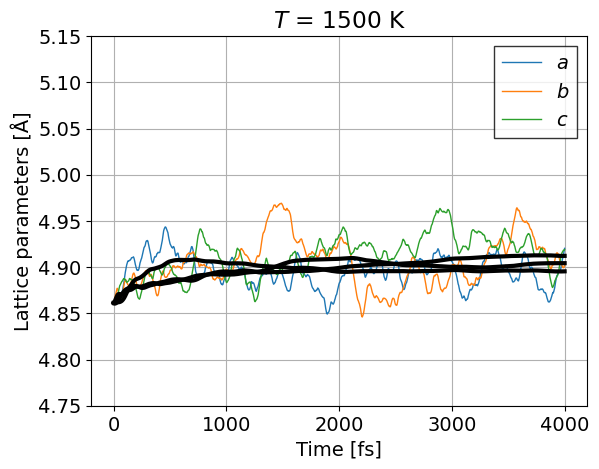

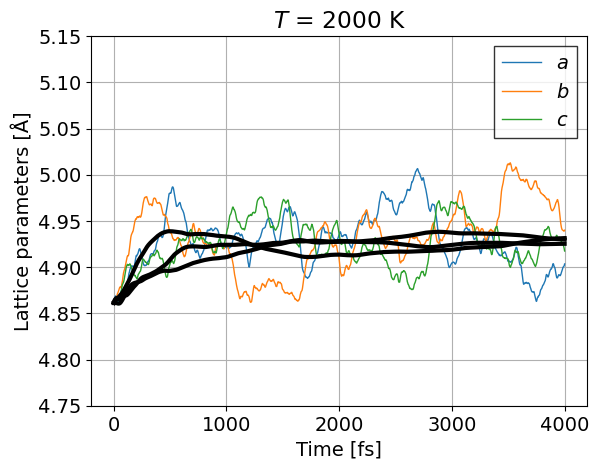

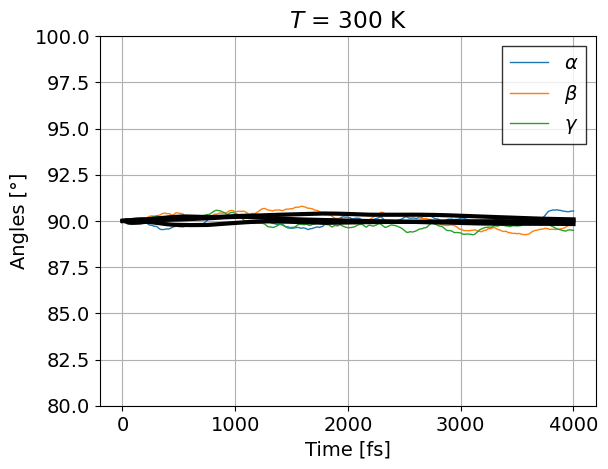

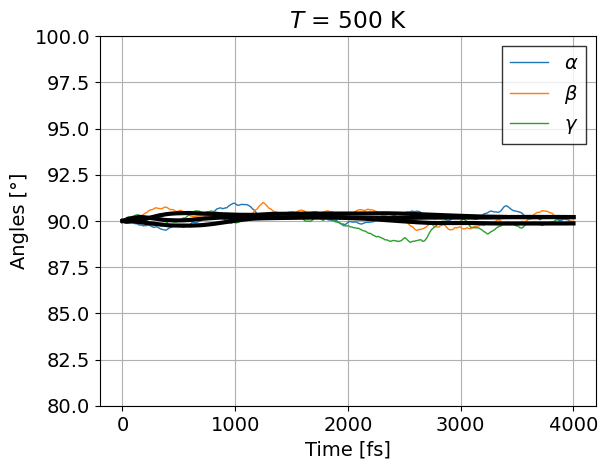

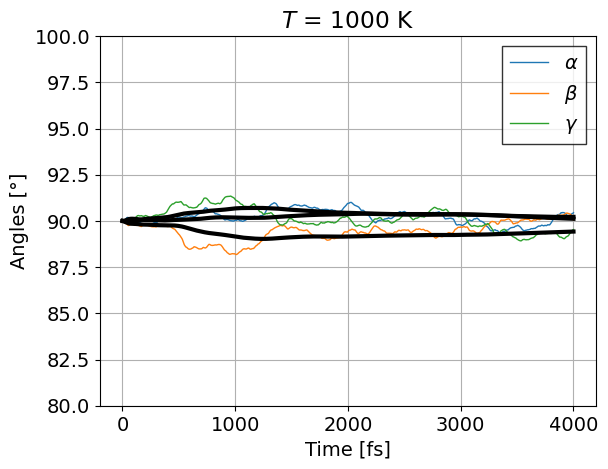

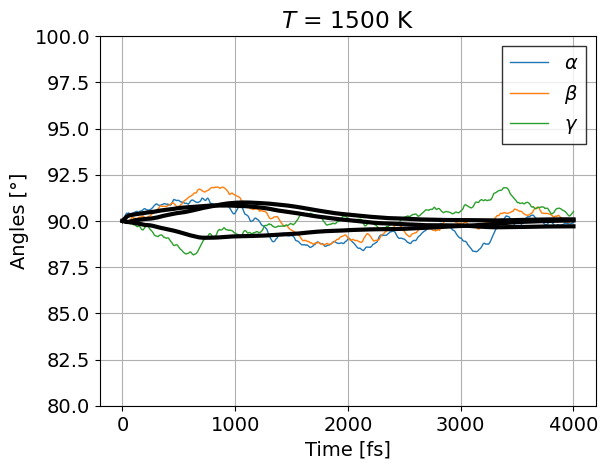

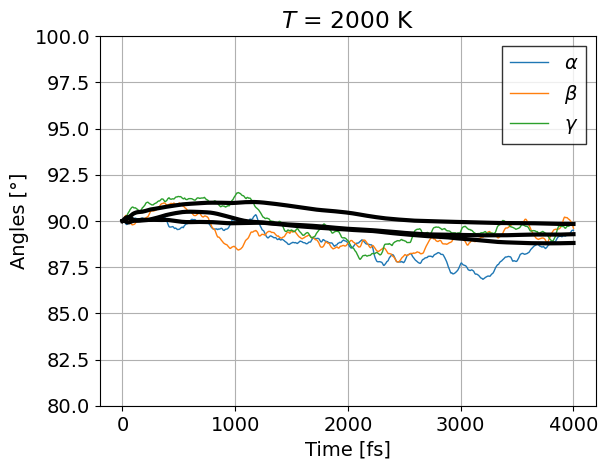

Fit parameters: [4.86174101e+00 1.59279778e-05 8.71886762e-09]
Uncertainties in fit parameters: [3.51327620e-03 7.69341879e-06 3.31653731e-09]
R^2: 99.63


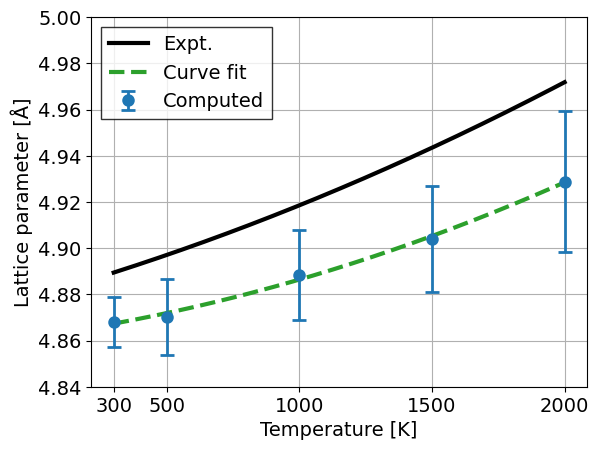

In [2]:
def vector_length(x, y, z):
    return math.sqrt(x**2 + y**2 + z**2)

def angle_between_vectors(v1, v2):
    dot_product = sum(i * j for i, j in zip(v1, v2))
    length_v1 = vector_length(*v1)
    length_v2 = vector_length(*v2)
    return math.degrees(math.acos(dot_product / (length_v1 * length_v2)))

def process_lattice_vectors(input_content):
    # Pattern to capture only direct lattice vector components
    pattern = r"direct lattice vectors\s+reciprocal lattice vectors\n\s*([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+[\d.-]+\s+[\d.-]+\s+[\d.-]+\n\s*([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+[\d.-]+\s+[\d.-]+\s+[\d.-]+\n\s*([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)"
    matches = re.findall(pattern, input_content)

    a_lengths, b_lengths, c_lengths = [], [], []
    alpha_angles, beta_angles, gamma_angles = [], [], []
    
    for match in matches:
        # Convert matches to float for calculations
        a1, a2, a3 = map(float, match[:3])
        b1, b2, b3 = map(float, match[3:6])
        c1, c2, c3 = map(float, match[6:])

        # Compute lengths and divide by 3
        a_lengths.append(vector_length(a1, a2, a3) / 3)
        b_lengths.append(vector_length(b1, b2, b3) / 3)
        c_lengths.append(vector_length(c1, c2, c3) / 3)

        # Compute angles
        alpha_angles.append(angle_between_vectors((b1, b2, b3), (c1, c2, c3)))
        beta_angles.append(angle_between_vectors((a1, a2, a3), (c1, c2, c3)))
        gamma_angles.append(angle_between_vectors((a1, a2, a3), (b1, b2, b3)))

    # Convert lists to NumPy arrays without reshaping
    a_lengths = np.array(a_lengths)
    b_lengths = np.array(b_lengths)
    c_lengths = np.array(c_lengths)
    alpha_angles = np.array(alpha_angles)
    beta_angles = np.array(beta_angles)
    gamma_angles = np.array(gamma_angles)

    return a_lengths, b_lengths, c_lengths, alpha_angles, beta_angles, gamma_angles

lengths = {}
for i in T:
    lengths[i] = [[], [], []]

angles = {}
for i in T:
    angles[i] = [[], [], []]

for i in T:
    with open(f'{HOME}/lattice.{i}.txt', 'r') as file:
        content = file.read()
    lengths[i][0], lengths[i][1], lengths[i][2], angles[i][0], angles[i][1], angles[i][2] = process_lattice_vectors(content)

for i in T:
    mpl.plot(data[i]["Timestep"], lengths[i][0], lw=1, label='$a$')
    mpl.plot(data[i]["Timestep"], lengths[i][1], lw=1, label='$b$')
    mpl.plot(data[i]["Timestep"], lengths[i][2], lw=1, label='$c$')
    mpl.plot(data[i]["Timestep"], running_average(lengths[i][0]), '-', linewidth=3, color='k')
    mpl.plot(data[i]["Timestep"], running_average(lengths[i][1]), '-', linewidth=3, color='k')
    mpl.plot(data[i]["Timestep"], running_average(lengths[i][2]), '-', linewidth=3, color='k')    
    mpl.xlabel("Time [fs]")
    mpl.ylabel("Lattice parameters [Å]")
    mpl.legend(fancybox=False, edgecolor='k', loc='upper right')
    mpl.grid(True)
    mpl.ylim(4.75, 5.15)
    mpl.savefig(f'LatConst-{i}.png', dpi=800, bbox_inches="tight")
    mpl.title(f"$T$ = {i} K")
    mpl.show()

for i in T:
    mpl.plot(data[i]["Timestep"], angles[i][0], lw=1, label='$α$')
    mpl.plot(data[i]["Timestep"], angles[i][1], lw=1, label='$β$')
    mpl.plot(data[i]["Timestep"], angles[i][2], lw=1, label='$γ$')
    mpl.plot(data[i]["Timestep"], running_average(angles[i][0]), '-', linewidth=3, color='k')
    mpl.plot(data[i]["Timestep"], running_average(angles[i][1]), '-', linewidth=3, color='k')
    mpl.plot(data[i]["Timestep"], running_average(angles[i][2]), '-', linewidth=3, color='k')    
    mpl.xlabel("Time [fs]")
    mpl.ylabel("Angles [°]")
    mpl.legend(fancybox=False, edgecolor='k', loc='upper right')
    mpl.grid(True)
    mpl.ylim(80, 100)
    mpl.savefig(f'Angles-{i}.png', dpi=800, bbox_inches="tight")
    mpl.title(f"$T$ = {i} K")
    mpl.show()

LatConst_av = []
LatConst_sigma = []

for i in T:
    # Combine a, b, and c lengths for each temperature
    combined = np.concatenate((lengths[i][0], lengths[i][1], lengths[i][2]))
    av = np.mean(combined)
    sigma = np.std(combined)
    LatConst_av.append(av)
    LatConst_sigma.append(sigma)

T1 = np.linspace(300, 2000, 500)

def a_expt(T): return 4.879+3.264e-5*T+6.889e-9*T**2

def a_func(T, a, b, c):
    return a + b*T + c*T**2

def r_squared(y, y_fit):
    residual_sum_of_squares = np.sum((y - y_fit) ** 2)
    total_sum_of_squares = np.sum((y - np.mean(y)) ** 2)
    return 1 - (residual_sum_of_squares / total_sum_of_squares)

params, covars = curve_fit(a_func, T, LatConst_av)

fit = a_func(np.array(T), *params)
R2 = r_squared(LatConst_av, fit)
uncertainty = np.sqrt(np.diag(covars))

print(f"Fit parameters: {params}")
print(f"Uncertainties in fit parameters: {uncertainty}")
print(f"R^2: {round(100*R2, 2)}")

mpl.plot(T1, a_expt(T1), '-', color='k', linewidth=3, label='Expt.')
mpl.rcParams.update({'lines.markeredgewidth': 2})
(_, caps, _) = mpl.errorbar(T, LatConst_av, yerr=LatConst_sigma, fmt='o', markersize=7, capsize=5, lw=2, color='tab:blue', label='Computed')
mpl.plot(T1, a_func(T1, *params), '--', color='tab:green', lw=3, label='Curve fit')

mpl.xticks([300, 500, 1000, 1500, 2000], ['300', '500', '1000', '1500', '2000'])
mpl.xlabel("Temperature [K]")
mpl.ylabel("Lattice parameter [Å]")
mpl.legend(fancybox=False, edgecolor='k', loc='upper left')
mpl.grid(True)
mpl.ylim(4.84, 5.00)
mpl.savefig('LatConst.png', dpi=800, bbox_inches="tight")
mpl.show()

-2387.242129325819 0.0558429924693448 7.489194379768677e-07 8.546918338976872e-10
R2: 99.9997
Uncertainty: [5.46518397e-01 2.03938328e-03 2.00944750e-06 5.71990954e-10]


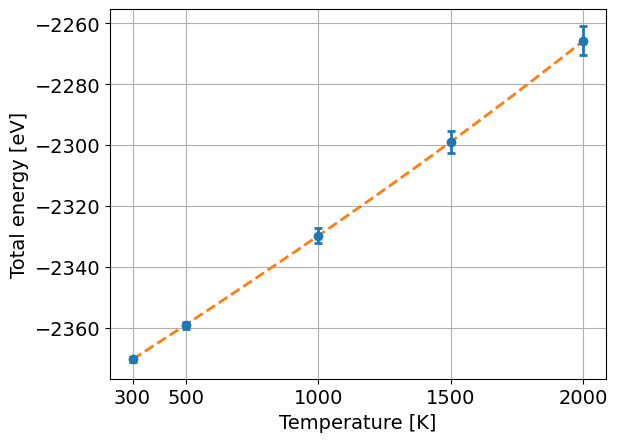

Mean Absolute Error: 7.2312
Root Mean Squared Error: 8.0934
Maximum Absolute Error: 16.076
Maximum Relative Error (%): 20.6621


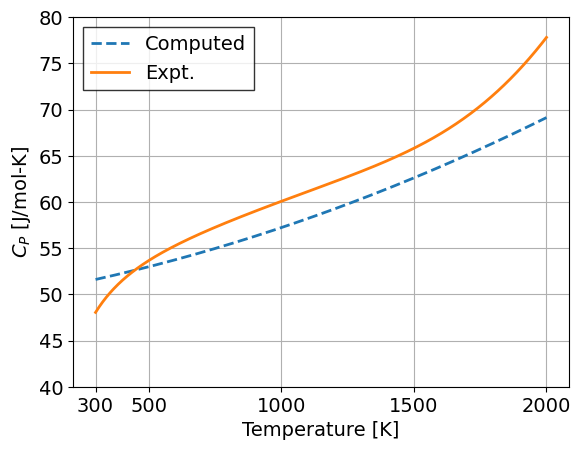

In [3]:
def quad(T, a, b, c, d): 
    return a + b*T + c*T**2 + d*T**3

params, covars = curve_fit(quad, T, TotE)
a, b, c, d = params
print(a, b, c, d)

fit = quad(np.array(T), *params)
R2 = r_squared(TotE, fit)
uncertainty = np.sqrt(np.diag(covars))
print("R2:", round(100*R2, 4))
print("Uncertainty:", uncertainty)

mpl.plot(T1, quad(T1, *params), "--", lw=2, color='tab:orange')
mpl.rcParams.update({'lines.markeredgewidth': 2})
(_, caps, _) = mpl.errorbar(T, TotE, yerr=TotE_sigma, fmt='o', markersize=5, capsize=3, lw=2, color='tab:blue')

mpl.xticks([300, 500, 1000, 1500, 2000], ['300', '500', '1000', '1500', '2000'])
mpl.xlabel("Temperature [K]")
mpl.ylabel("Total energy [eV]")
mpl.grid(True)
# mpl.ylim(40, 80)
mpl.savefig(f'TotEvsT.png', dpi=800, bbox_inches="tight")
mpl.show()

NA = 6.02214076e23
atoms = 216
pairs = atoms/2
moles = pairs/NA
eV2J = 1.602176634e-19

def CP(T):
    return (1/moles) * (b + 2*c*T + 3*d*T**2) * eV2J

TE = 367.5
def ExptCP(T):
    return 51.14*(TE/T)**2*np.exp(TE/T)/(np.exp(TE/T)-1)**2 + 9.491e-3*T + 2.6414e11*np.exp(-18081/T)/T**2

# Calculate errors between CP and ExptCP
def calculate_errors(T, CP, ExptCP):
    # Absolute error
    abs_error = np.abs(CP(T) - ExptCP(T))
    # Relative error (percentage error)
    rel_error = (abs_error / ExptCP(T)) * 100
    # Mean Absolute Error (MAE)
    mae = np.mean(abs_error)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean(abs_error**2))
    return abs_error, rel_error, mae, rmse

# Calculate errors
abs_error, rel_error, mae, rmse = calculate_errors(T1, CP, ExptCP)

# Print the errors
print("Mean Absolute Error:", round(mae, 4))
print("Root Mean Squared Error:", round(rmse, 4))
print("Maximum Absolute Error:", round(np.max(abs_error), 4))
print("Maximum Relative Error (%):", round(np.max(rel_error), 4))

mpl.plot(T1, CP(T1)+3.7e-3*T1, "--", lw=2, label="Computed")
mpl.plot(T1, ExptCP(T1), "-", lw=2, label="Expt.")
mpl.xticks([300, 500, 1000, 1500, 2000], ['300', '500', '1000', '1500', '2000'])
mpl.xlabel("Temperature [K]")
mpl.ylabel("$C_P$ [J/mol-K]")
mpl.legend(fancybox=False, edgecolor='k', loc='upper left')
mpl.grid(True)
mpl.ylim(40, 80)
mpl.savefig('CP.png', dpi=800, bbox_inches="tight")
mpl.show()

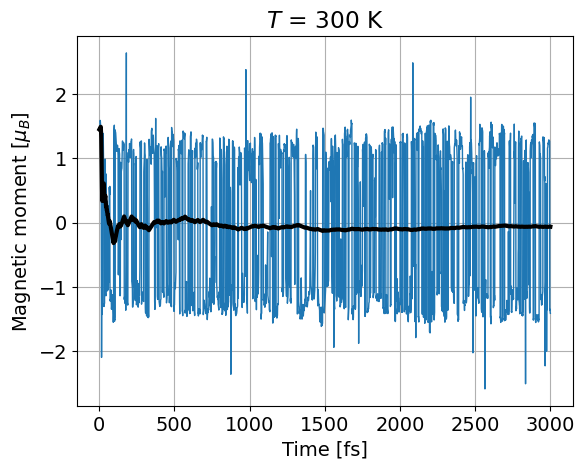

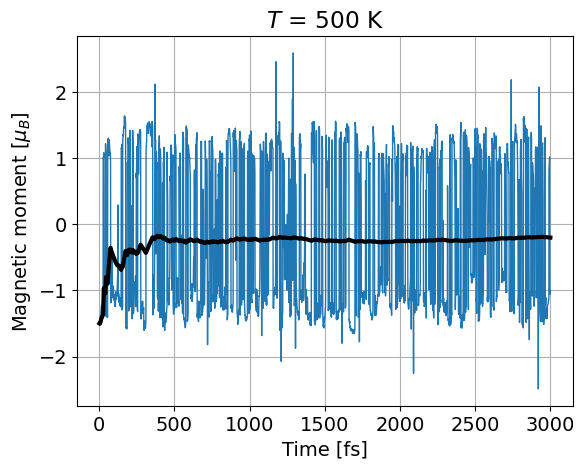

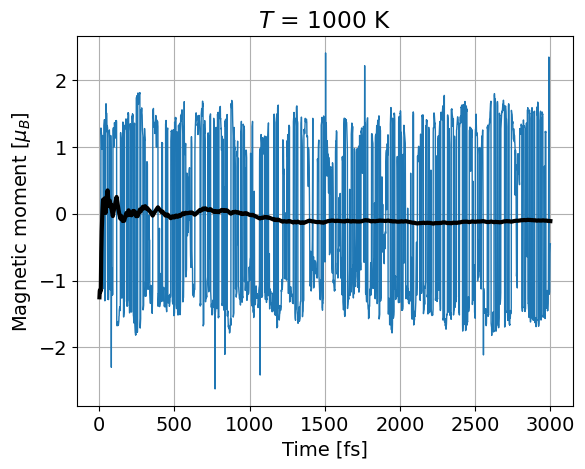

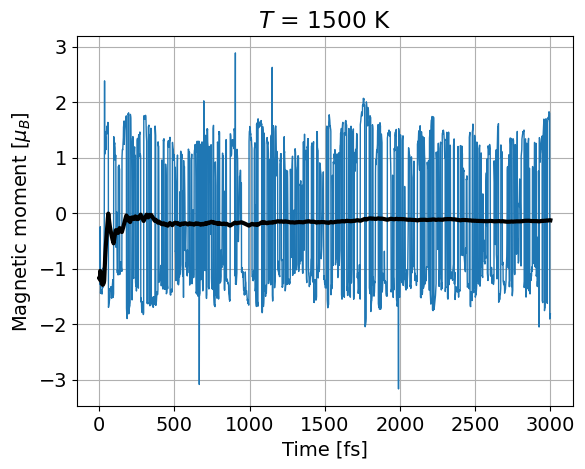

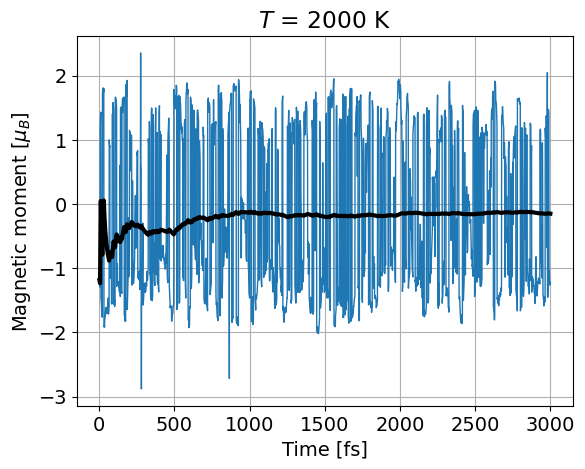

In [ ]:
atom_magmom = {}
T = [300, 500, 1000, 1500, 2000]
for i in T:
    atom_magmom[i] = []

timesteps = np.arange(1001, 4001)

for i in T:
    data = np.loadtxt(f'{HOME}/atom_mag_mom.{i}.out')
    atom_magmom[i] = data[:, -1]
    mpl.plot(timesteps, atom_magmom[i], "-", lw=1)
    mpl.plot(timesteps, running_average(atom_magmom[i]), '-', lw=3, color='k')
    mpl.xlabel("Time [fs]")
    mpl.ylabel("Magnetic moment [$\mu_B$]")
    # mpl.legend(fancybox=False, edgecolor='k', loc='upper left')
    mpl.grid(True)
    # mpl.ylim(40, 80)
    mpl.savefig(f'AtomMagMom-{i}.png', dpi=800, bbox_inches="tight")
    mpl.title(f"$T$ = {i} K")
    mpl.show()